In [1]:
import os
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.preprocessing import normalize

from IPython.display import display
from PIL import Image

from datasets.wafer import WM811K
from datasets.wafer import WM811KForSimCLR
from datasets.cifar import CustomCIFAR10
from datasets.cifar import CIFAR10ForSimCLR
from models.config import RESNET_BACKBONE_CONFIGS
from models.resnet.backbone import ResNetBackbone
from models.head import AttentionProjector
from tasks.attnclr import AttnCLR

# Load AttnCLR model from checkpoint

In [2]:
# Model configurations
cfg = dict(
    data='cifar10',
    in_channels=3,
    backbone_type='resnet',
    backbone_config='18.original',
    projector_type='mlp',
    projector_size=128,
)

In [3]:
backbone = ResNetBackbone(
    layer_config=RESNET_BACKBONE_CONFIGS[cfg['backbone_config']],
    in_channels=cfg['in_channels'])
print(backbone)

ResNetBackbone(
  (layers): Sequential(
    (block0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (block1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (block2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): Bat

In [4]:
head = AttentionProjector(
    in_channels=backbone.out_channels,
    num_features=cfg['projector_size'],
)
print(head)

AttentionProjector(
  (nonlinear): Sequential(
    (gap): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten()
    (linear): Linear(in_features=512, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
  )
  (q_linear): Linear(in_features=128, out_features=128, bias=False)
  (k_linear): Linear(in_features=128, out_features=128, bias=False)
  (v_linear): Linear(in_features=128, out_features=128, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [109]:
model_dir = "../checkpoints/cifar10/attnclr/resnet.18.original/2020-07-28_11:59:29"
model_file = os.path.join(model_dir, "best_model.pt")
assert os.path.isfile(model_file), "Check model file."

In [110]:
backbone.load_weights_from_checkpoint(model_file, key='backbone')
head.load_weights_from_checkpoint(model_file, key='projector')

# Load data

In [111]:
from datasets.transforms import CIFAR10Transform

In [112]:
transform = CIFAR10Transform(size=(32, 32), mode='pretrain')
print(transform)

CIFAR10Transform((32, 32), pretrain)


In [113]:
train_set = CIFAR10ForSimCLR(root='../data/cifar10/', train=True, transform=transform)
test_set = CIFAR10ForSimCLR(root='../data/cifar10/', train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [114]:
print(f"Train : Validation : Test = {len(train_set):,} : {len(test_set):,}")
print(f"Sum: {len(train_set) + len(test_set):,}")

Train : Validation : Test = 50,000 : 10,000
Sum: 60,000


# Get AttnCLR embeddings

In [125]:
from entmax import sparsemax

In [129]:
def inference(dataset: torch.utils.data.Dataset, backbone: nn.Module, head: nn.Module, device: str, **kwargs):
    
    B = 1024
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=B,
        shuffle=True,
        num_workers=0,
        drop_last=True)
    
    backbone = backbone.to(device)
    head     = head.to(device)
    
    backbone.eval()
    head.eval()
    
    penultimates = torch.empty(len(dataset), head.in_channels)
    projected    = torch.empty(len(dataset), head.num_features)
    targets      = torch.empty(len(dataset), dtype=torch.long)
    attention    = torch.empty(len(dataset), 2 * B)
    
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
        
            x1, x2 = batch['x1'].to(device), batch['x2'].to(device)
            y = batch['y'].to(device)
            idx = batch['idx']
            
            penl = backbone(torch.cat([x1, x2], dim=0))
            proj, attn = head(penl)
            
            mask = torch.eye(x1.size(0), device=attn.device).repeat(2, 2)
            negative_mask = 1. - mask
            masked_attn = attn * negative_mask
            masked_attn.div_(0.07)
            masked_attn = sparsemax(masked_attn, dim=-1)
            attn = masked_attn
            
            penl = penl[:B]
            proj = proj[:B]
            attn = attn[:B]
            
            penultimates[idx] = nn.AdaptiveAvgPool2d(1)(penl).view(penl.size(0), -1).cpu()
            projected[idx] = proj.cpu()
            
            penultimates[idx] = nn.AdaptiveAvgPool2d(1)(penl).view(penl.size(0), -1).cpu()
            projected[idx]    = proj.cpu()
            attention[idx]    = attn.cpu()
            
            try:
                targets[idx] = batch['y'].cpu()
            except KeyError:
                targets[idx] = -1
                
    out = dict(
        penultimates=penultimates,
        projected=projected,
        targets=targets,
        attention=attention,
    )
    
    backbone = backbone.to('cpu')
    head     = head.to('cpu')
    
    return out

In [130]:
DEVICE = 'cuda:0'

In [131]:
%%time
results = inference(
    dataset=train_set,
    backbone=backbone,
    head=head,
    device=DEVICE
)

CPU times: user 1min 44s, sys: 1.18 s, total: 1min 45s
Wall time: 1min 33s


In [132]:
attn_scores = results['attention']
attn_scores = attn_scores.cpu().numpy()

In [133]:
targets = results['targets']
targets = targets.cpu().numpy()

In [134]:
from torchvision.transforms import ToPILImage

In [135]:
np.unique(attn_scores.flatten(), return_counts=True)

(array([0.0000000e+00, 4.8828125e-04, 1.0000000e+00], dtype=float32),
 array([102250545,    100352,     49103]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

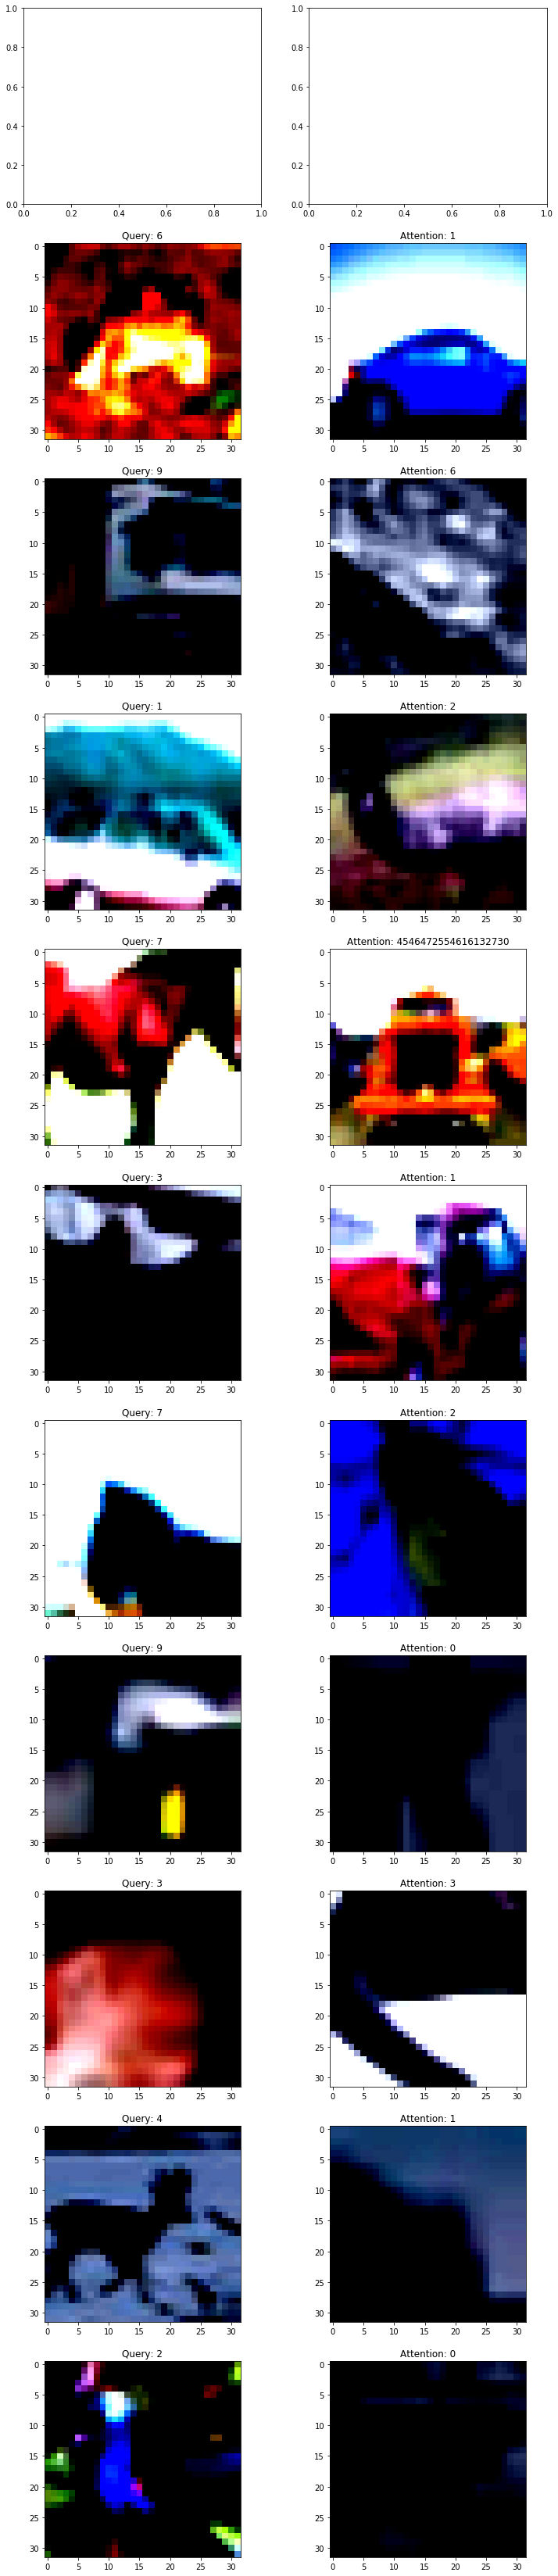

In [136]:
maxi = 10
fig, axes = plt.subplots(nrows=maxi+1, ncols=2, figsize=(12, 60))

c = 0
for i, attn in enumerate(attn_scores):
    
    if c >= maxi:
        break
    
    j = attn.argmax()
    if j >= 1024:
        continue
    
    if False:
    #if targets[i] != targets[j]:
        continue
    
    c += 1
    axes[c][0].imshow(train_set[i]['x1'].permute(1, 2, 0).numpy())
    axes[c][1].imshow(train_set[j]['x1'].permute(1, 2, 0).numpy())
    axes[c][0].set_title(f"Query: {targets[i]}")
    axes[c][1].set_title(f"Attention: {targets[j]}")


In [28]:
i = 5
print(attn_scores[i].max())
print(attn_scores[i].argmax())

1.0
428


In [21]:
attn_scores[1].argmax()

992

In [44]:
for i, attn in enumerate(attn_scores):
    cond = attn == 0.
    if cond.sum() > 0:
        print(i)
        break

34


(array([1.73670400e+06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00663296e+08]),
 array([0.0000000e+00, 4.8828126e-05, 9.7656251e-05, 1.4648438e-04,
        1.9531250e-04, 2.4414062e-04, 2.9296876e-04, 3.4179687e-04,
        3.9062501e-04, 4.3945311e-04, 4.8828125e-04], dtype=float32),
 <a list of 10 Patch objects>)

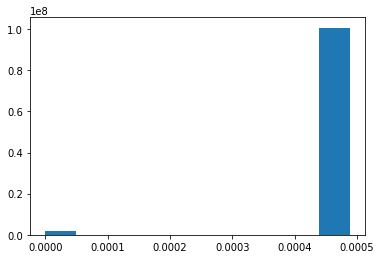

In [36]:
plt.hist(attn_scores.flatten())

In [34]:
attn_scores.flatten()

array([0.00048828, 0.00048828, 0.00048828, ..., 0.00048828, 0.00048828,
       0.00048828], dtype=float32)

In [32]:
attn_scores.max()

0.00048828125

In [33]:
attn_scores.min()

0.0

In [21]:
%%time
train_penultimates, train_embeddings, train_targets = predict_embeddings(train_set, backbone=backbone, head=head, device=DEVICE)

CPU times: user 8min 55s, sys: 13.1 s, total: 9min 8s
Wall time: 1min 37s


In [22]:
%%time
test_penultimates, test_embeddings, test_targets = predict_embeddings(test_set, backbone=backbone, head=head, device=DEVICE)

CPU times: user 1min 8s, sys: 1.59 s, total: 1min 10s
Wall time: 12.5 s


In [24]:
# Convert to numpy arrays
train_penultimates, train_embeddings, train_targets = train_penultimates.numpy(), train_embeddings.numpy(), train_targets.numpy()
test_penultimates, test_embeddings, test_targets   = test_penultimates.numpy(), test_embeddings.numpy(), test_targets.numpy()

In [25]:
# Normalize such that |v| = 1 (i.e. independently normalize each sample)
l2norm_configs = dict(norm='l2', axis=1, return_norm=False)

train_penultimates = normalize(train_penultimates, **l2norm_configs)
test_penultimates = normalize(test_penultimates, **l2norm_configs)

train_embeddings = normalize(train_embeddings, **l2norm_configs)
test_embeddings  = normalize(test_embeddings, **l2norm_configs)

# Nearest Neighbors

In [27]:
nn_configs = dict(metric='euclidean', n_neighbors=5, n_jobs=16)
neigh = NearestNeighbors(**nn_configs)

In [28]:
%%time
neigh.fit(train_penultimates)

CPU times: user 28.6 s, sys: 129 ms, total: 28.8 s
Wall time: 28.6 s


NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=16, n_neighbors=5, p=2, radius=1.0)

In [29]:
%%time
neigh_dist, neigh_ind = neigh.kneighbors(X=test_penultimates, return_distance=True)

CPU times: user 1h 10min 34s, sys: 1.2 s, total: 1h 10min 35s
Wall time: 4min 50s


In [30]:
neigh_dist

array([[0.57979136, 0.59914825, 0.61647133, 0.62784801, 0.63064617],
       [0.        , 0.45566113, 0.45566113, 0.46521809, 0.47494372],
       [0.        , 0.60144788, 0.60727067, 0.63430159, 0.63662383],
       ...,
       [0.4714417 , 0.51787524, 0.51863332, 0.52296796, 0.5275393 ],
       [0.44549888, 0.4729075 , 0.51249384, 0.51602021, 0.53136406],
       [0.42897103, 0.47847673, 0.49157507, 0.51448856, 0.52004536]])

In [31]:
neigh_ind

array([[  1293,   1288,   1279,   1423,   2182],
       [  2773,  30406,  23501,  73794,   2720],
       [  2796,   1584,  27115,  19988,  17817],
       ...,
       [ 93670,  93502,  15752,  92812, 122518],
       [136068, 126334,  41010, 136686,  42632],
       [  6739,  94570,  91999, 122329, 124580]])

In [53]:
LABEL_OF_INTEREST = 'none'
MAX_COUNT = 100

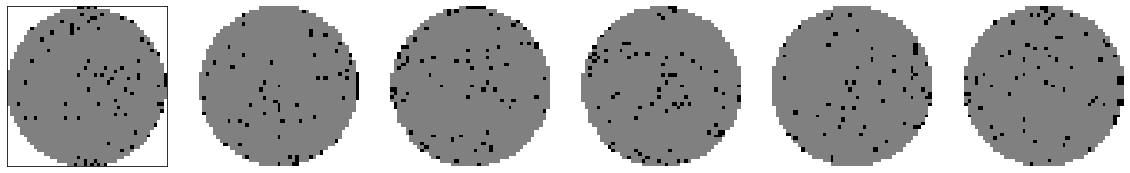

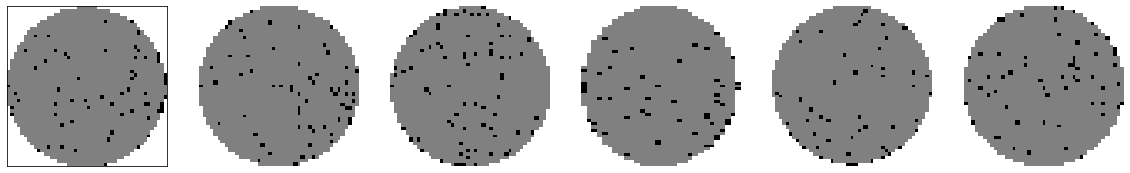

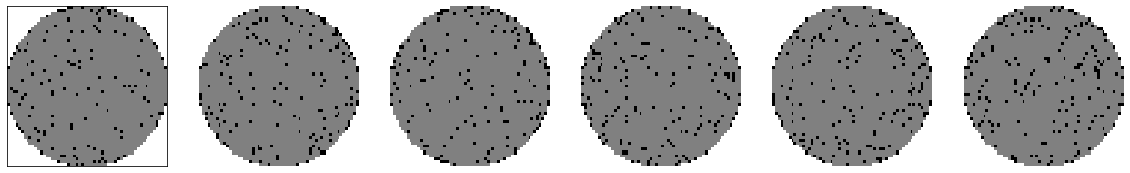

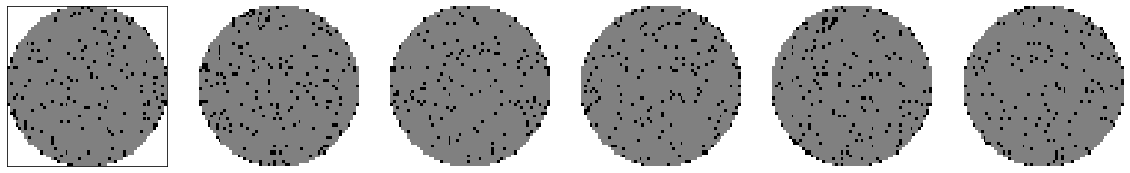

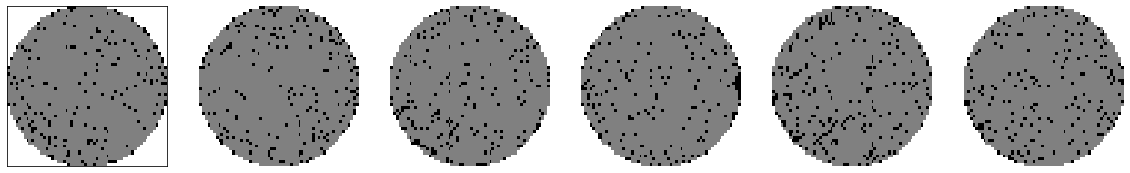

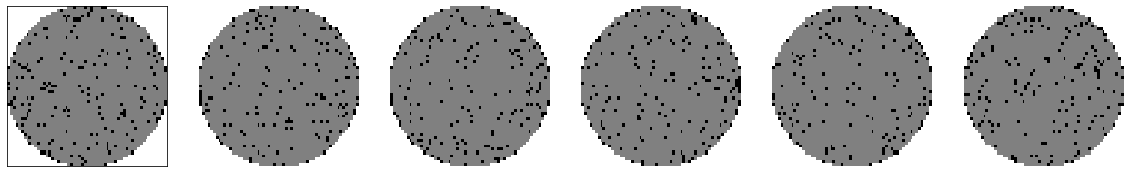

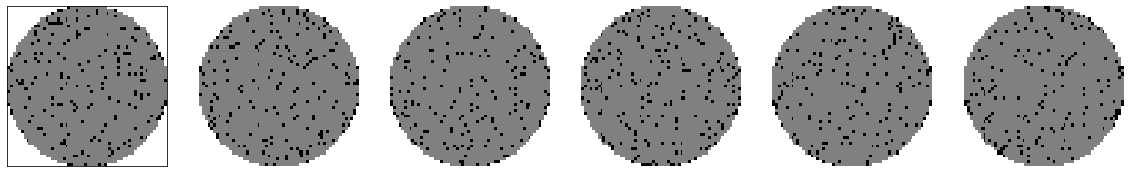

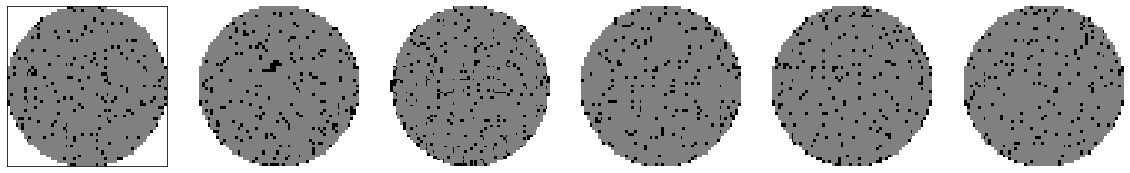

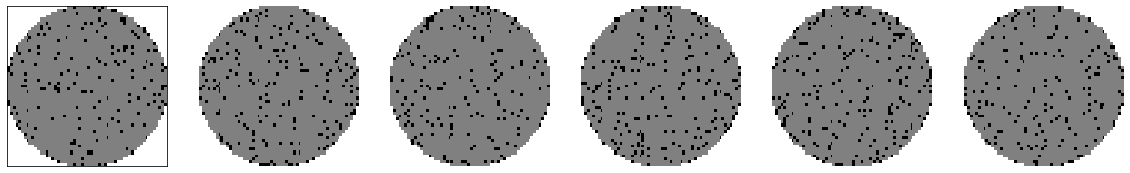

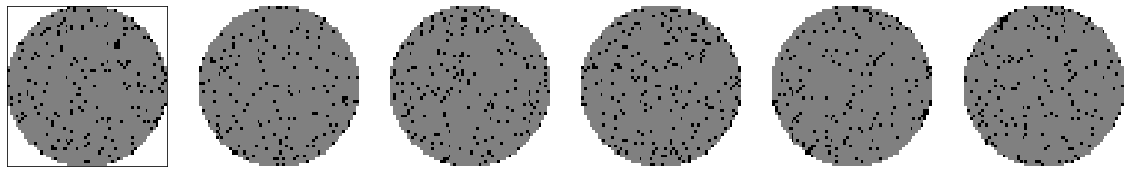

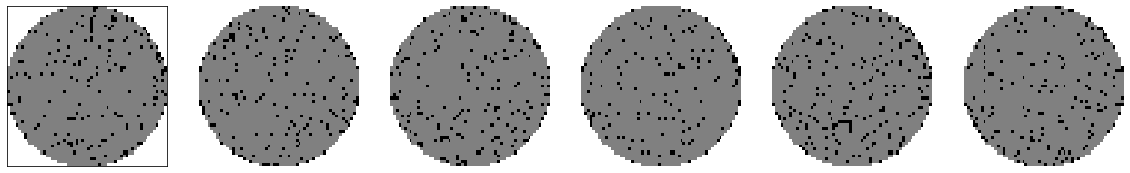

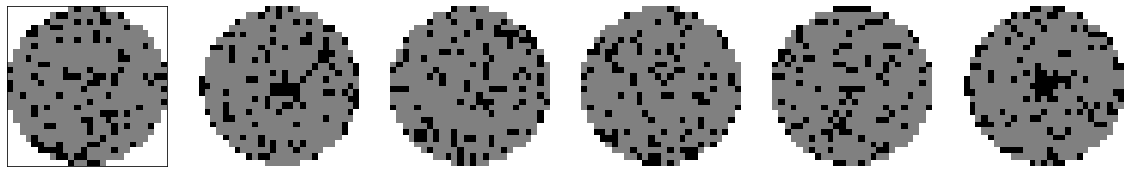

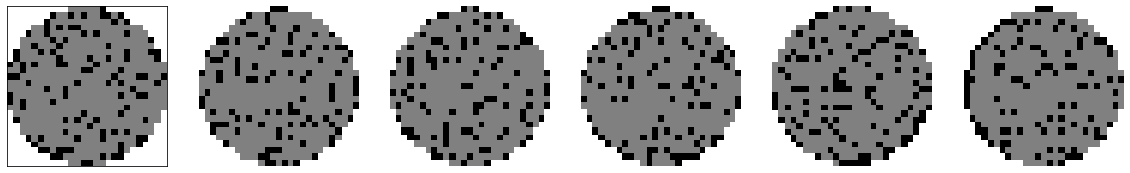

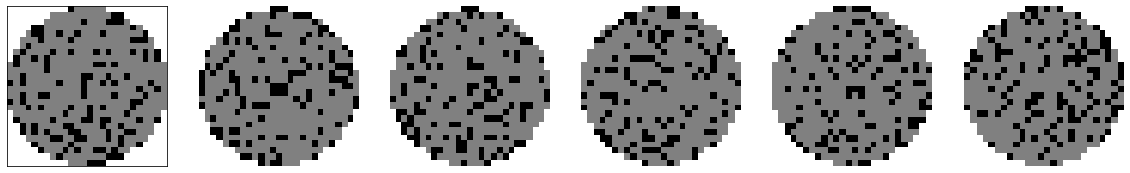

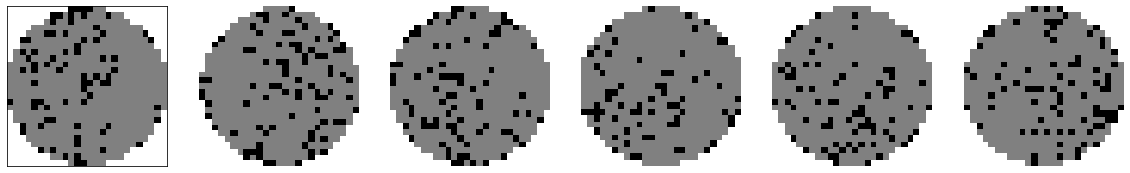

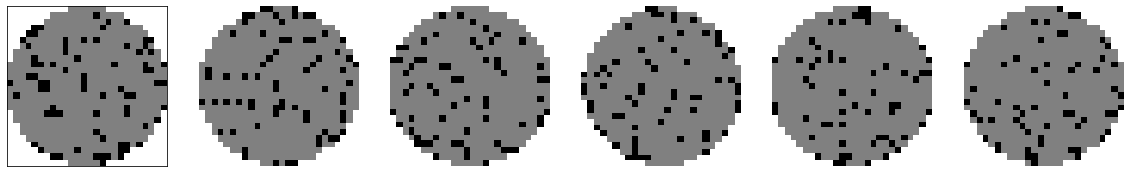

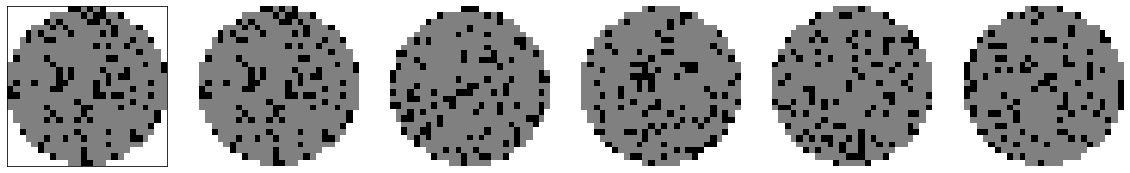

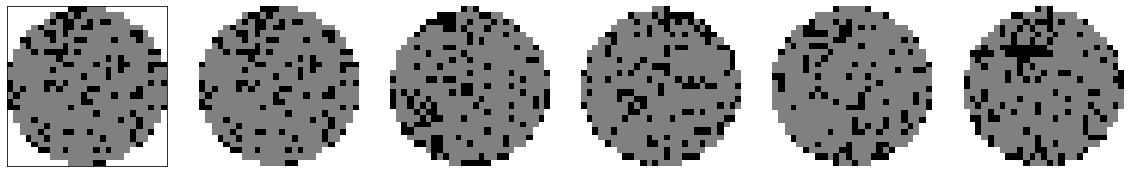

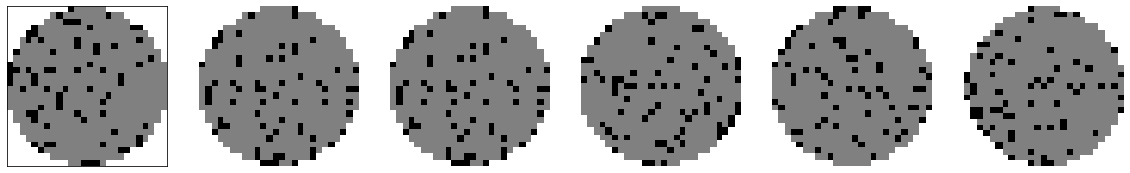

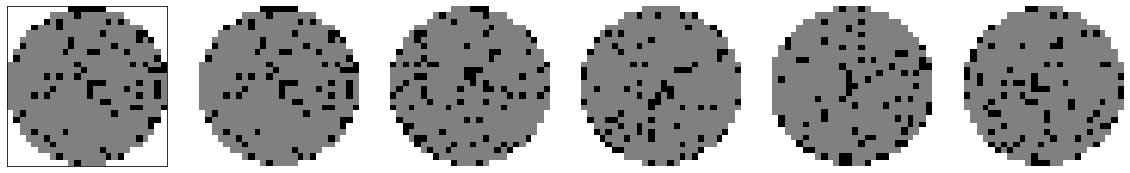

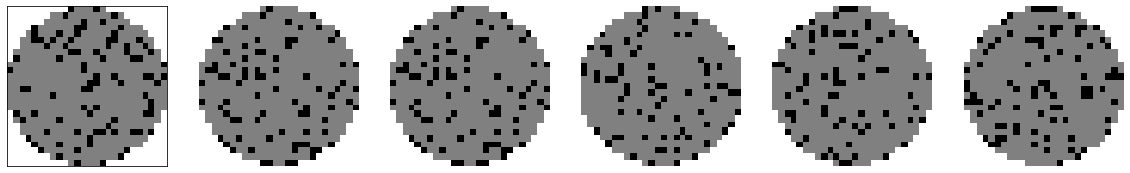

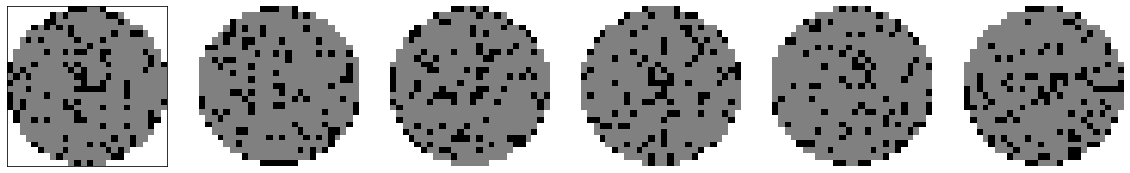

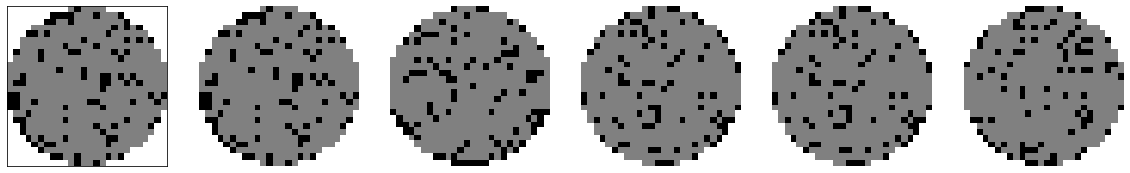

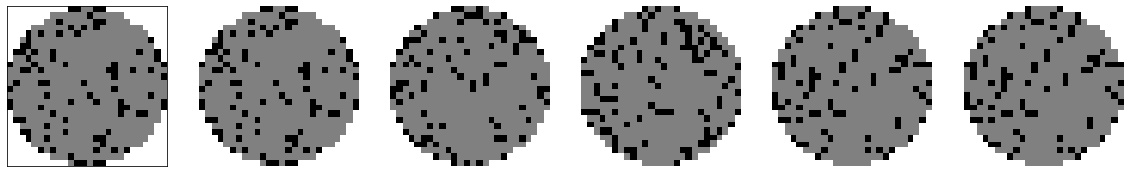

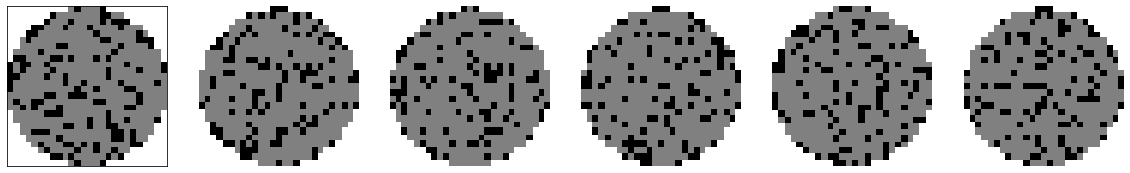

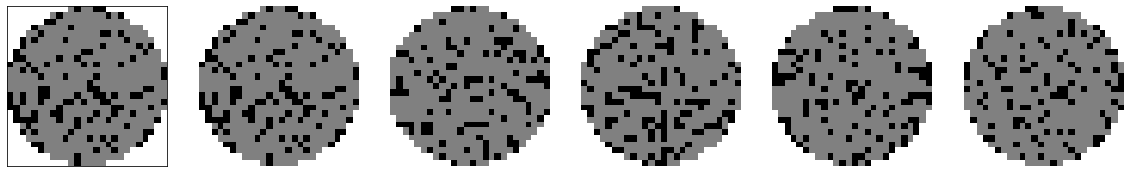

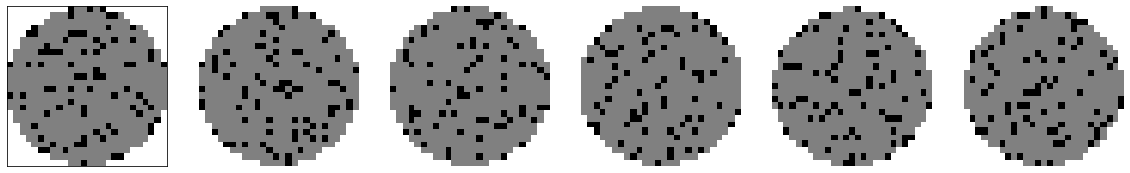

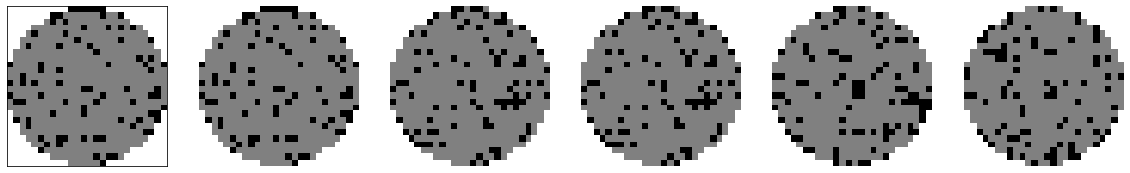

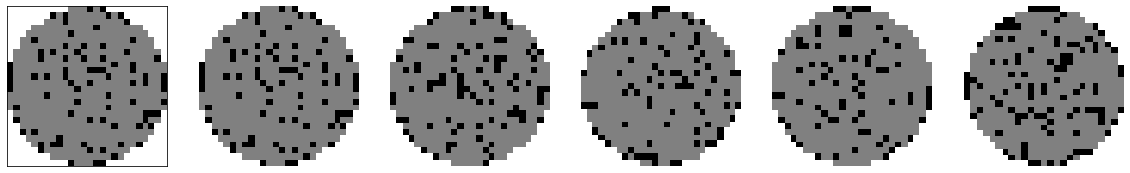

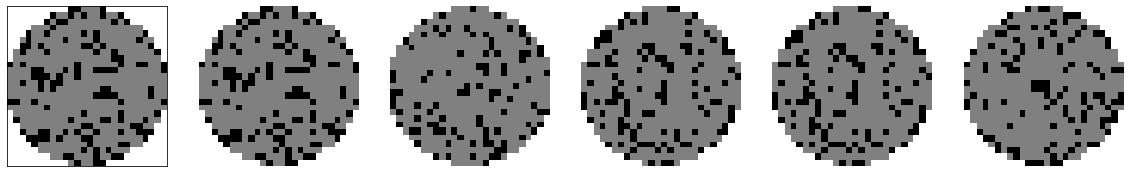

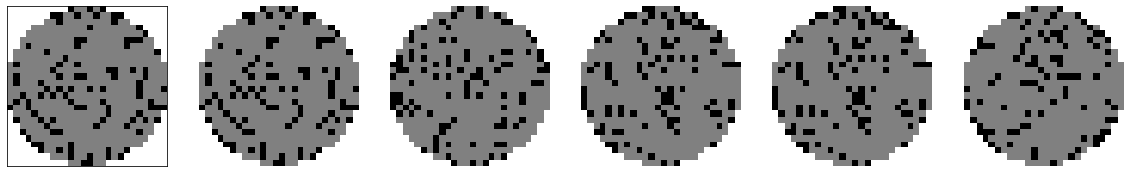

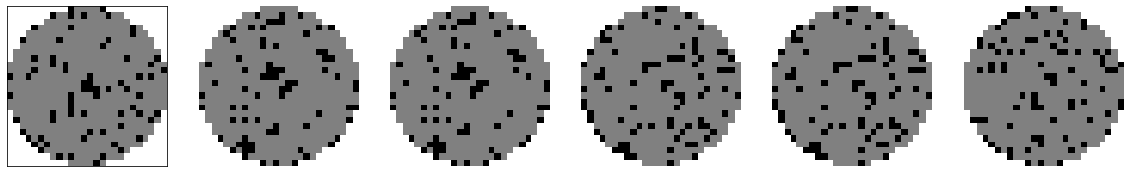

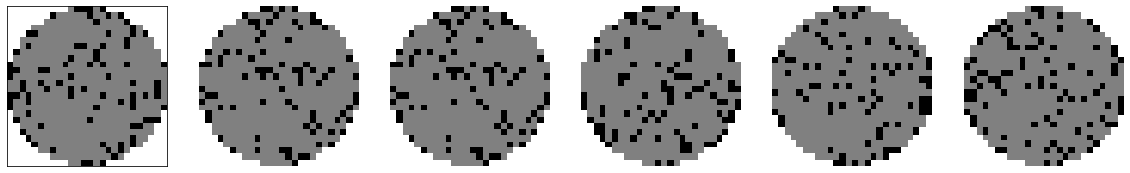

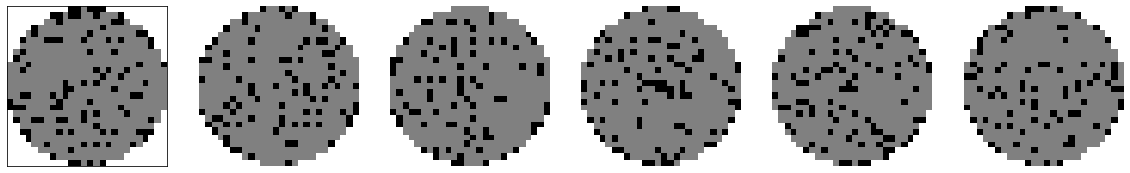

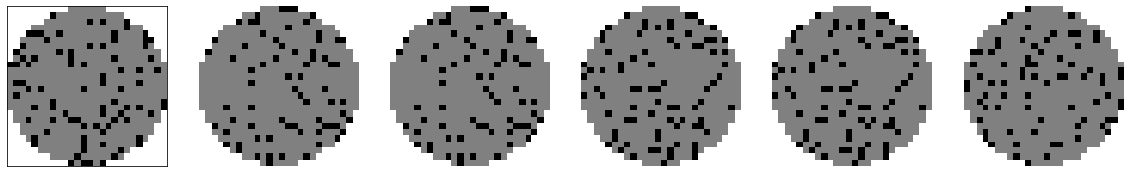

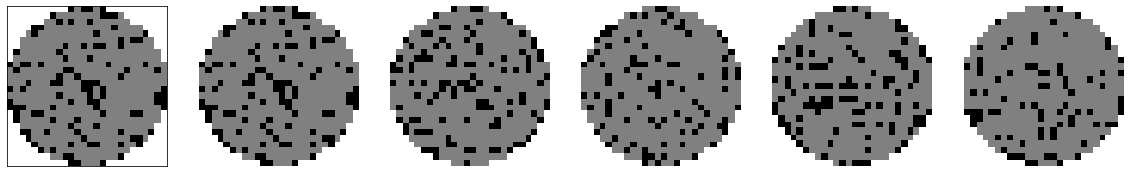

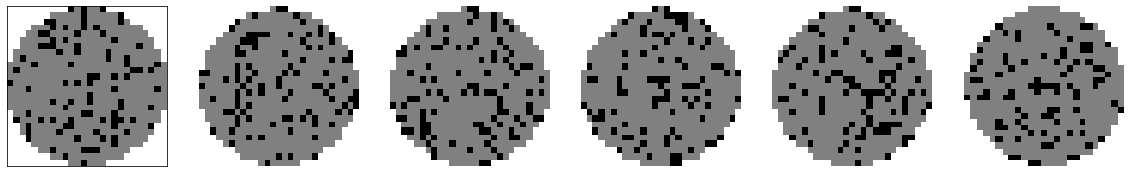

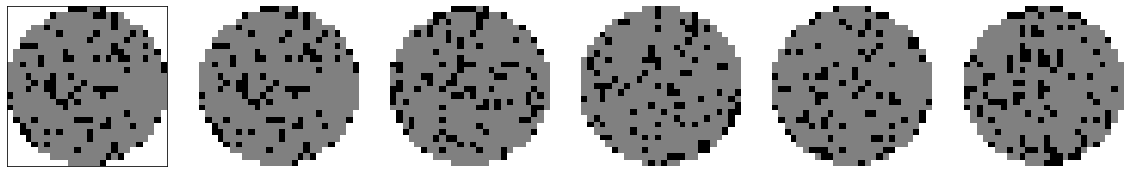

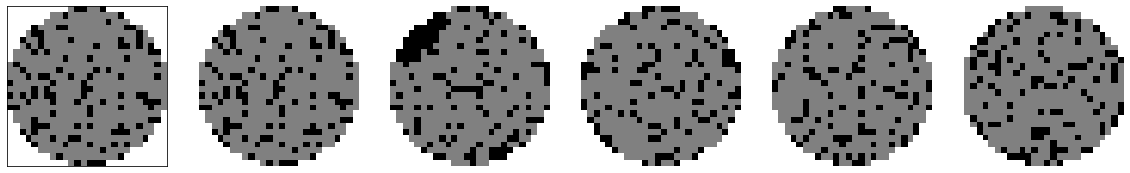

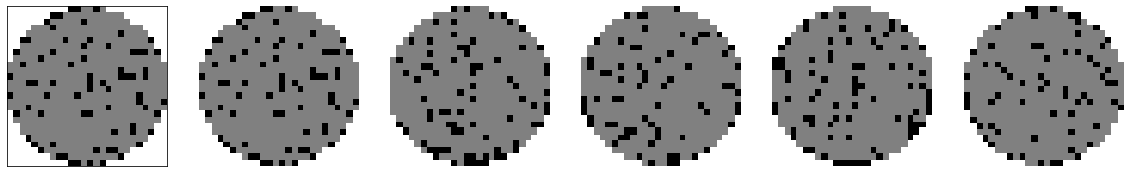

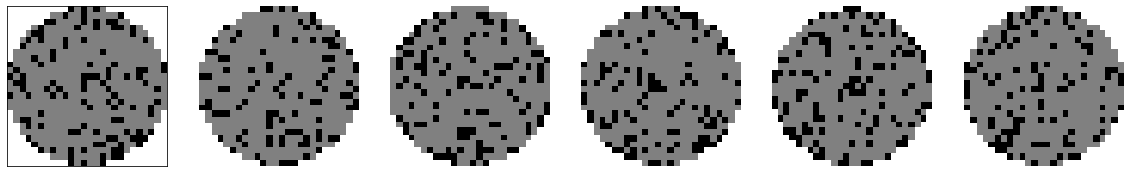

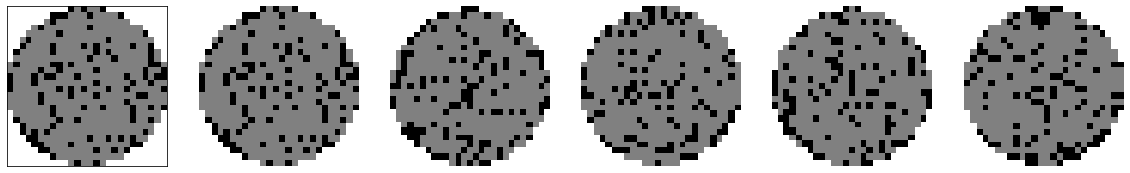

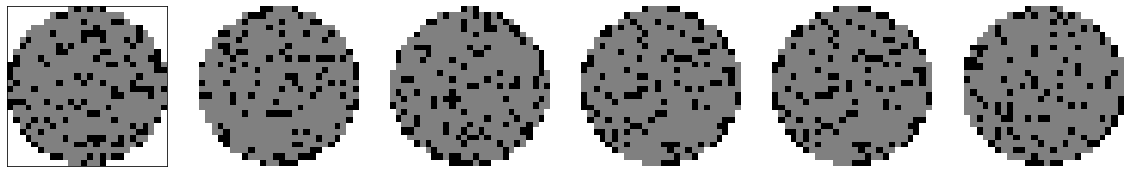

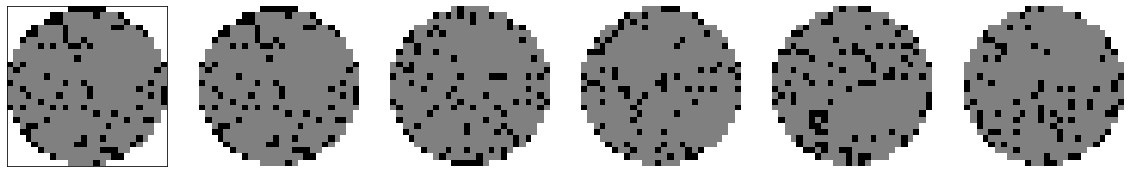

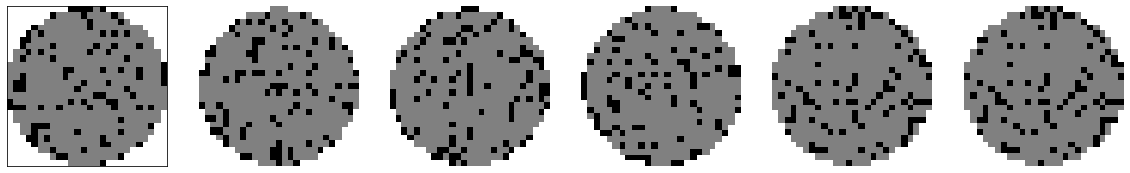

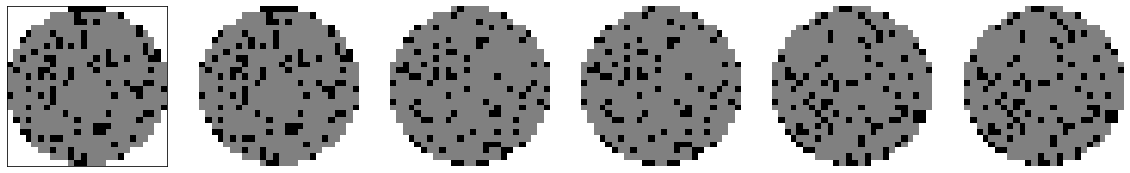

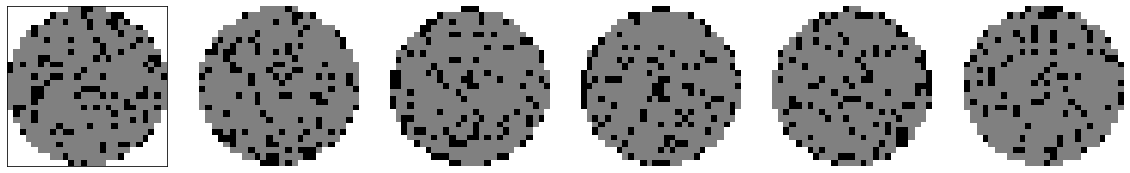

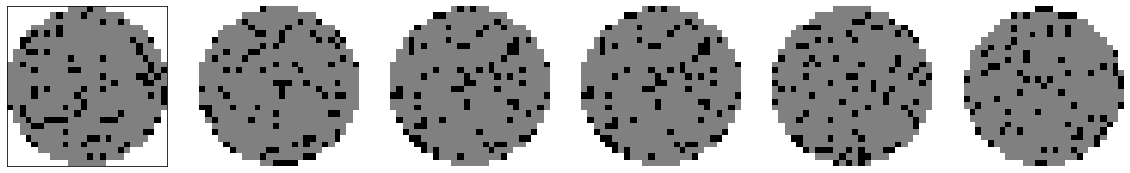

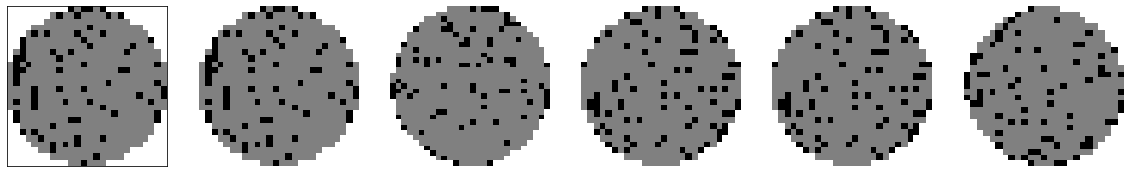

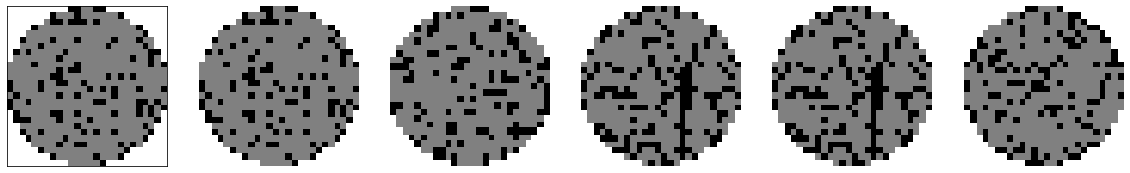

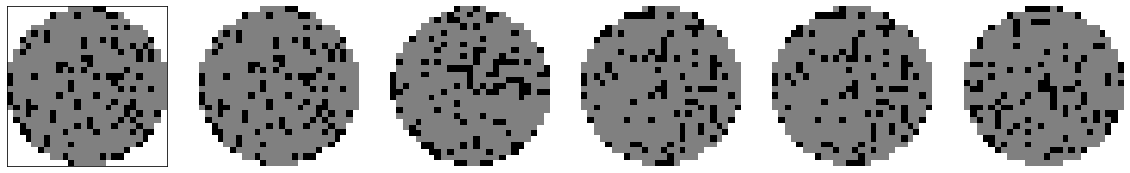

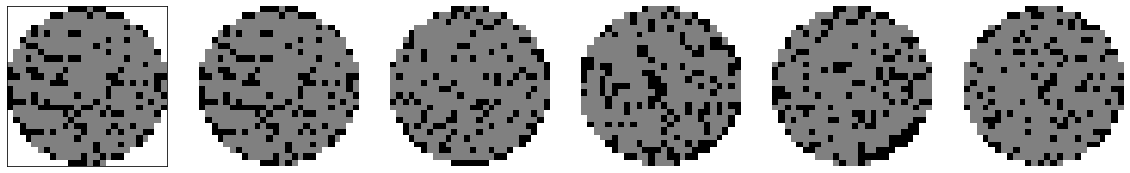

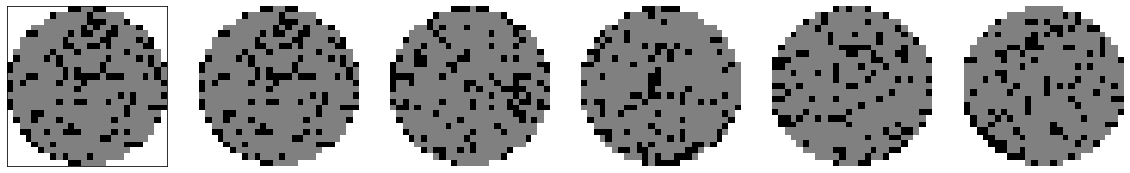

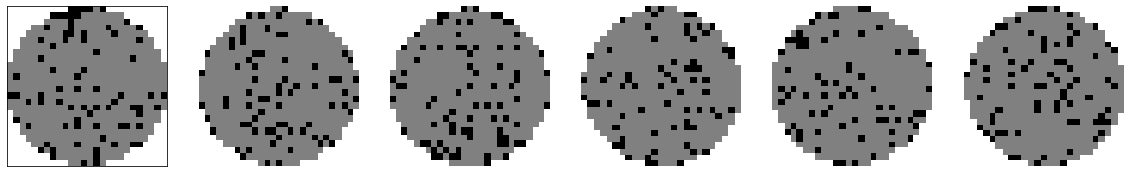

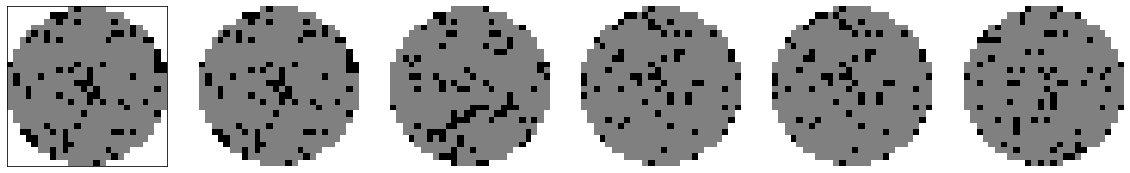

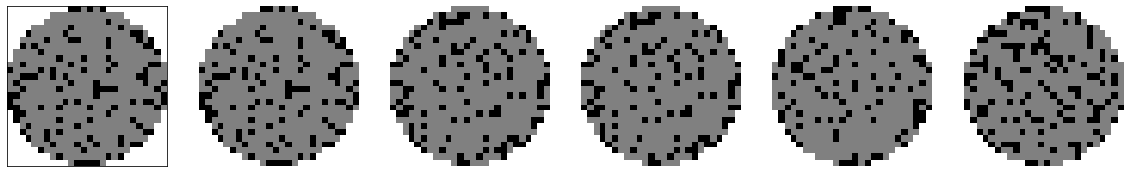

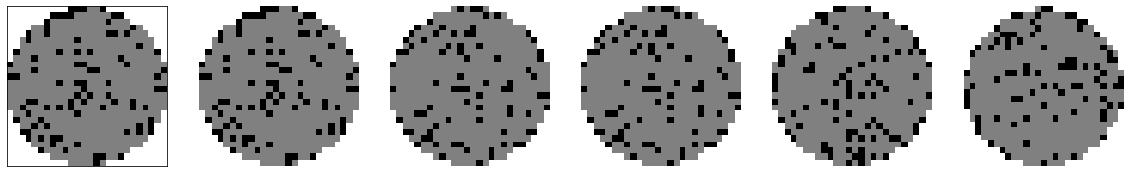

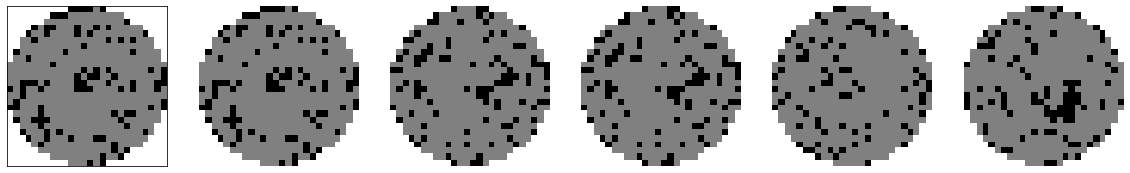

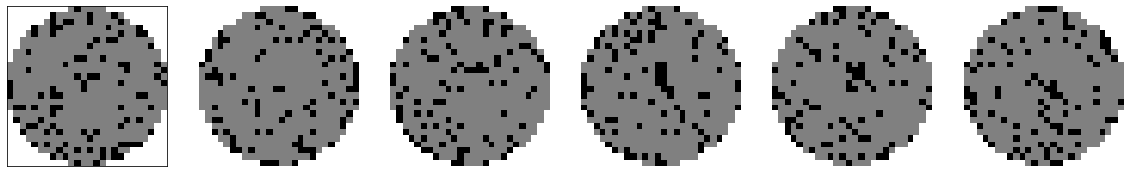

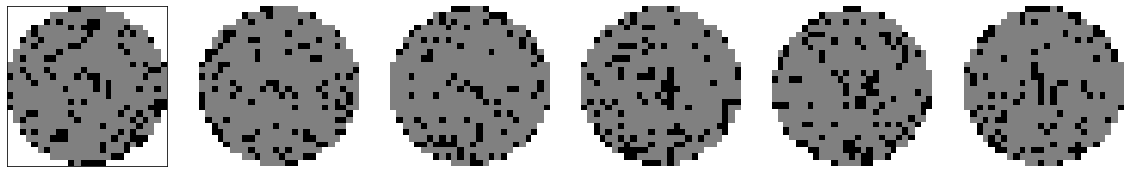

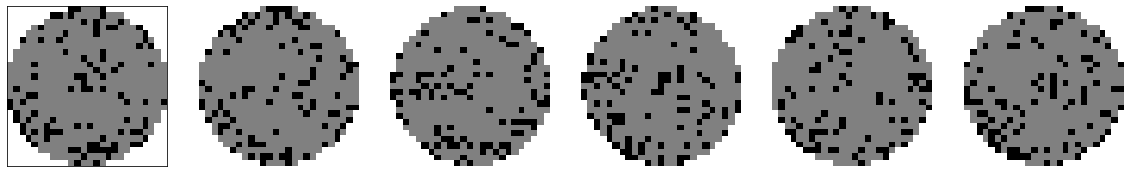

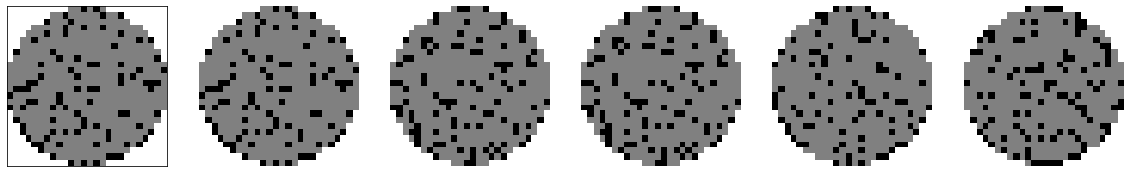

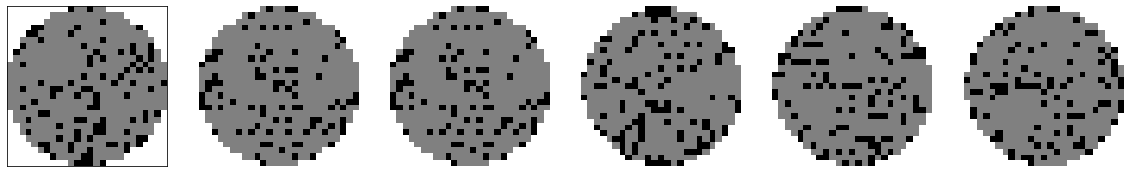

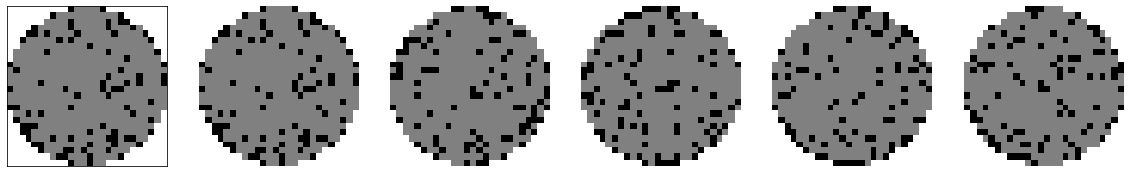

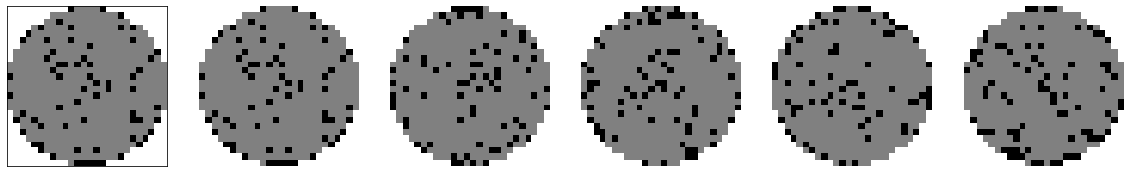

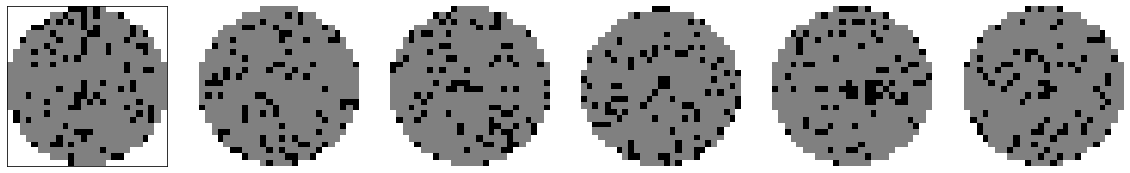

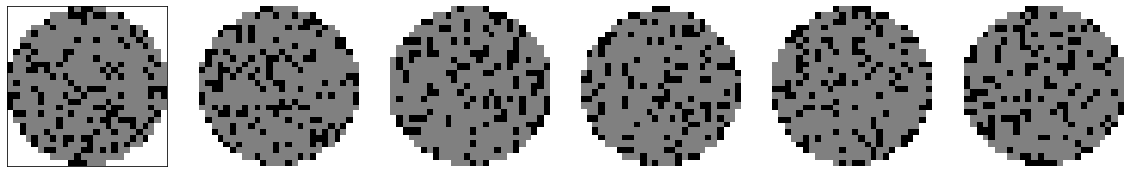

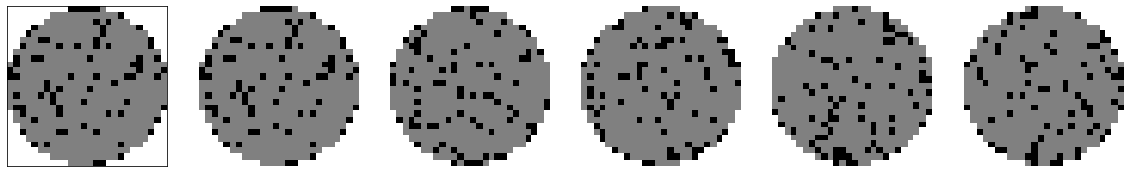

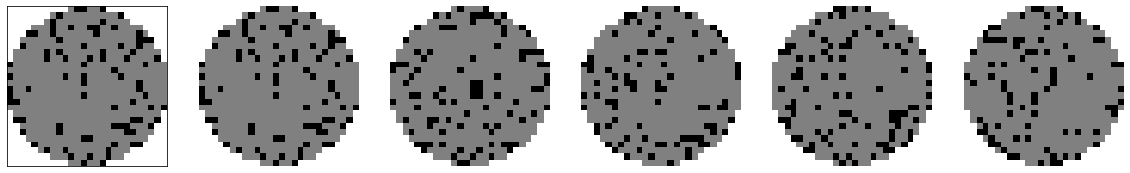

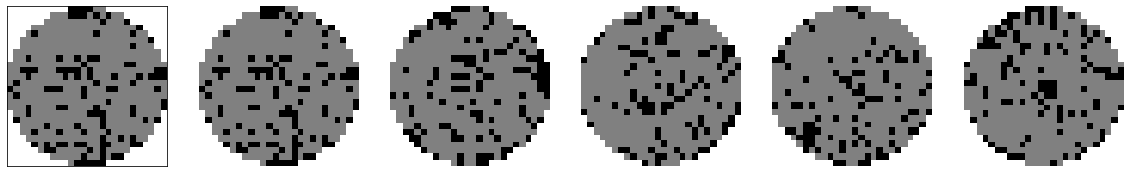

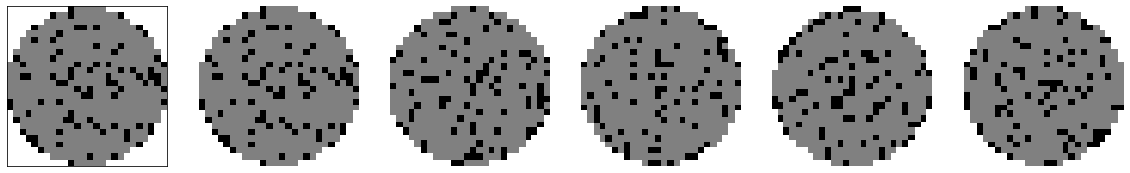

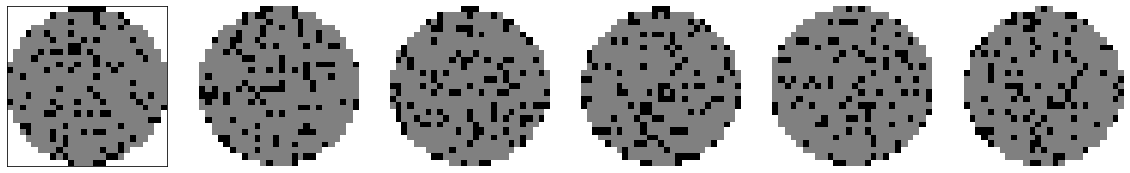

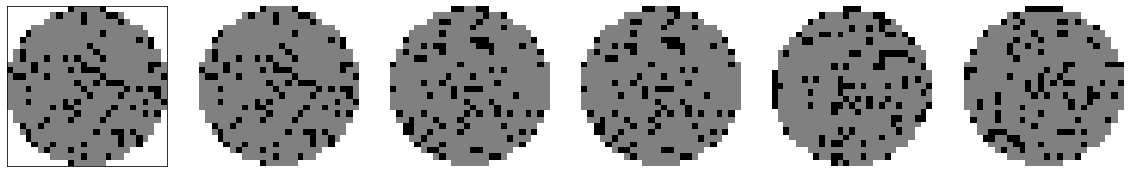

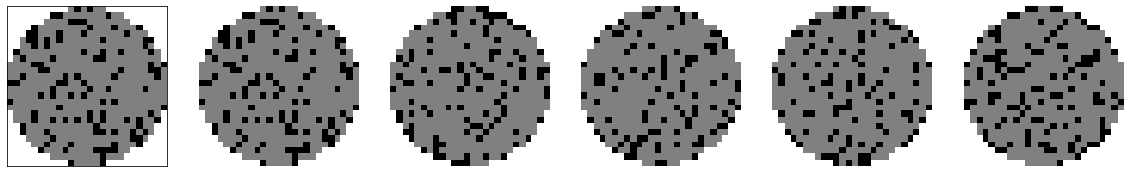

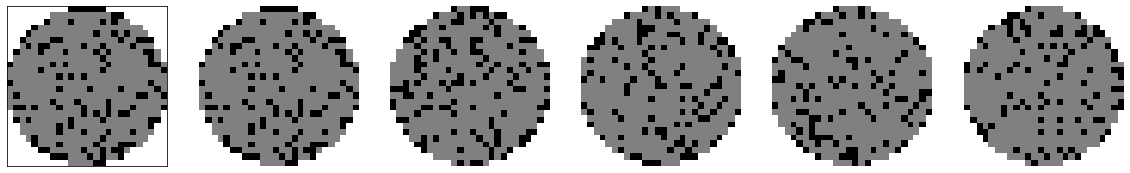

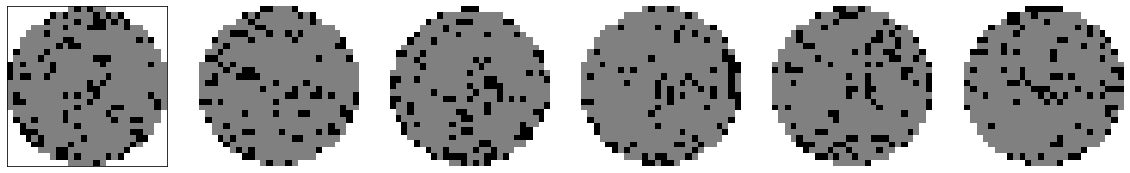

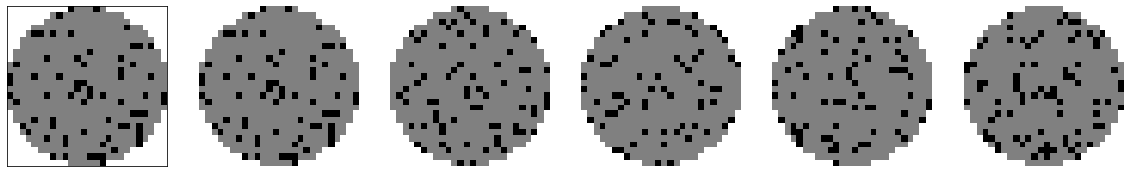

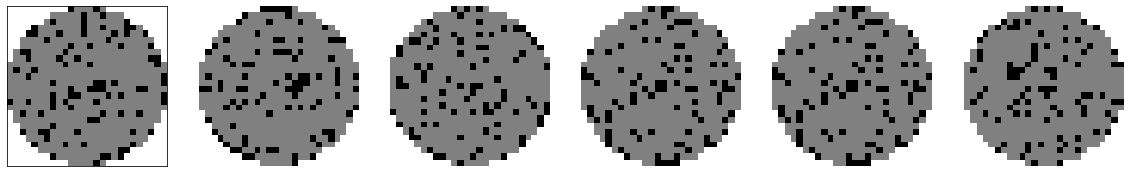

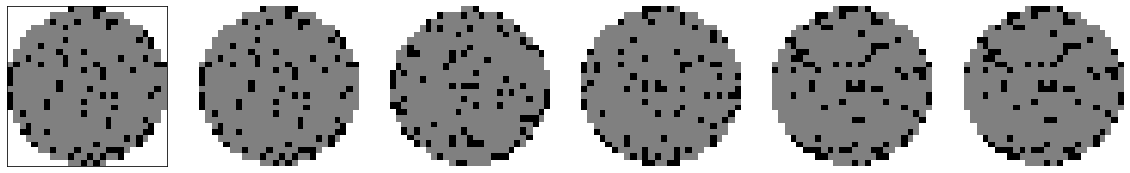

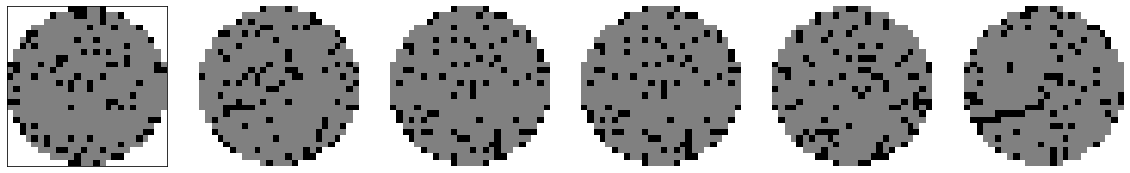

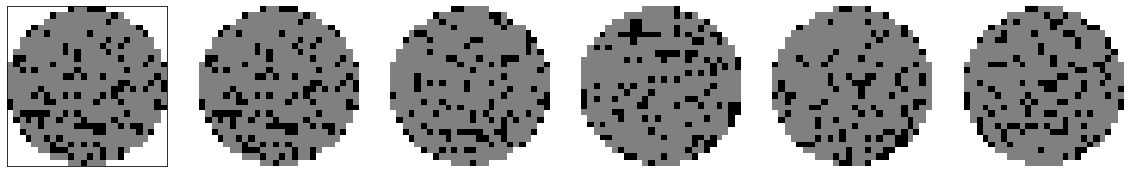

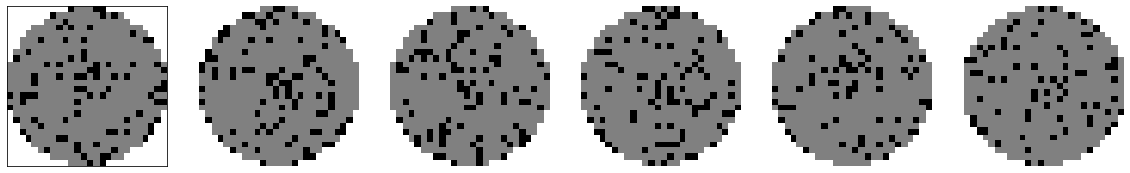

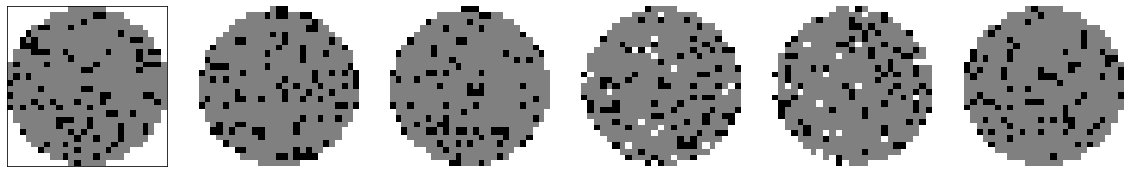

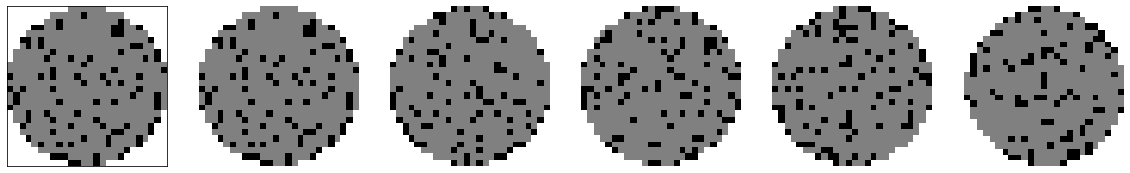

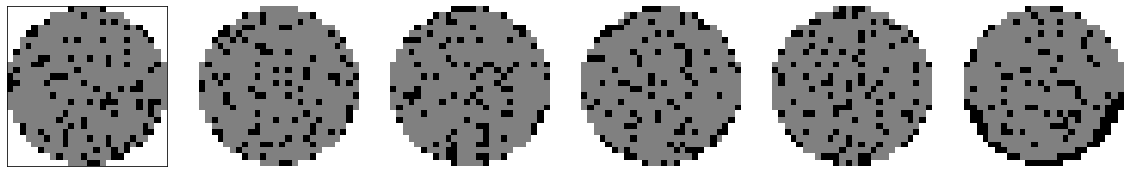

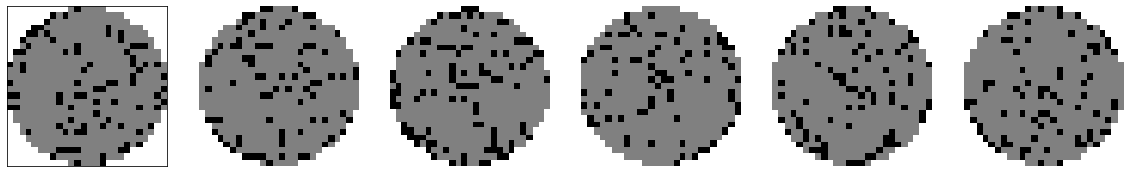

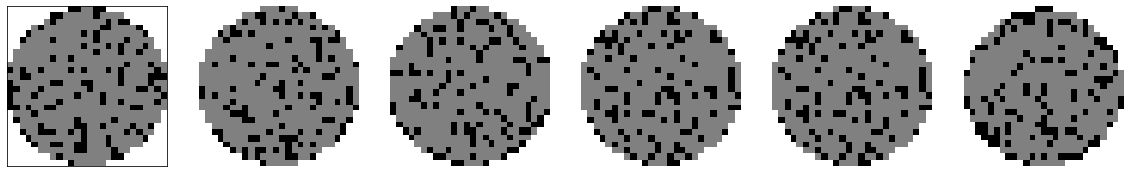

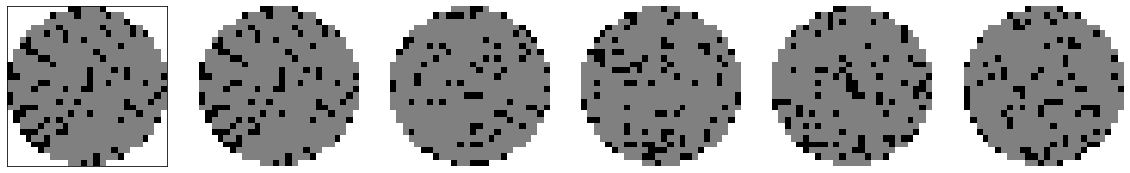

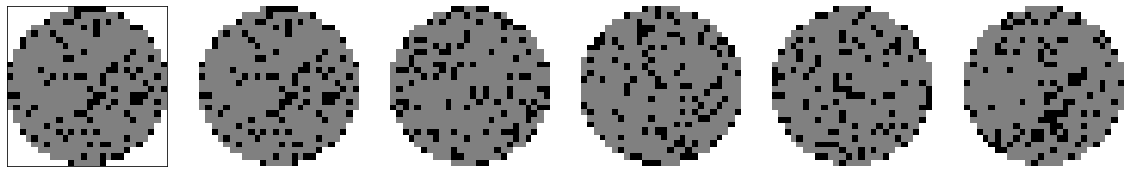

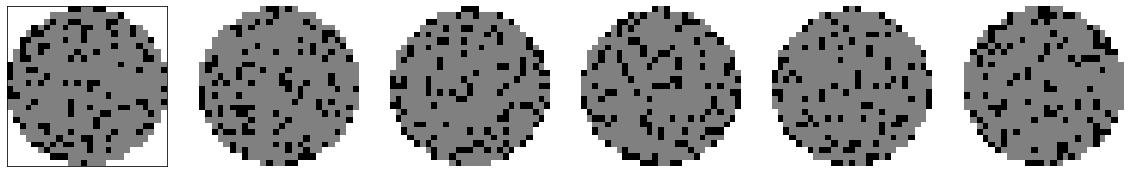

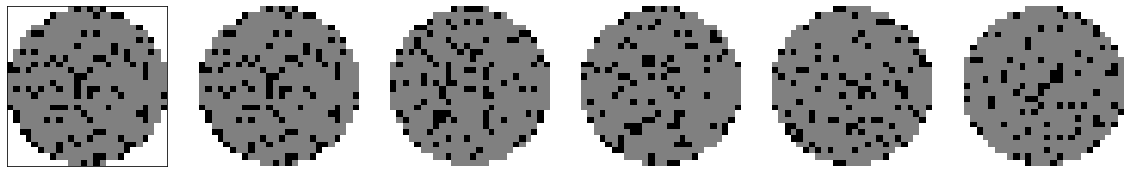

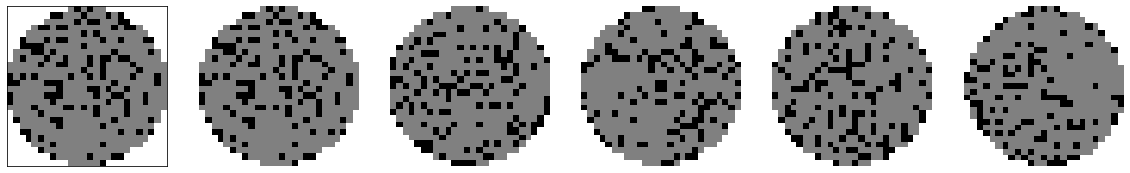

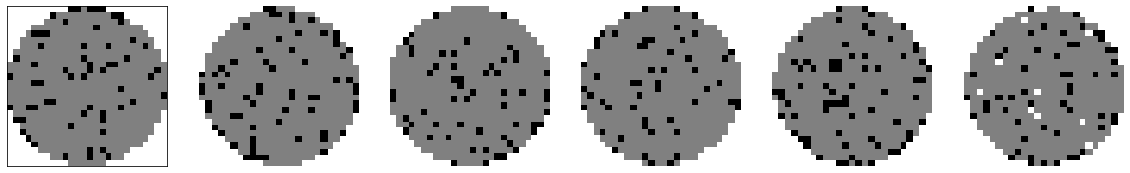

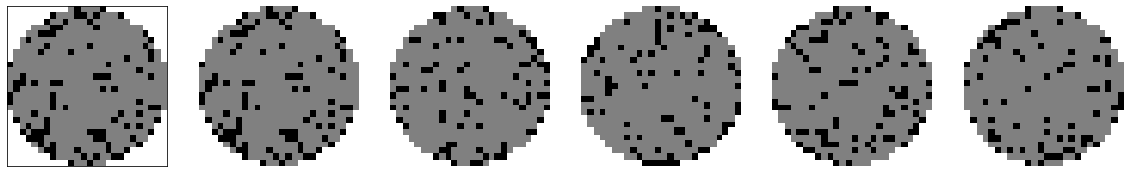

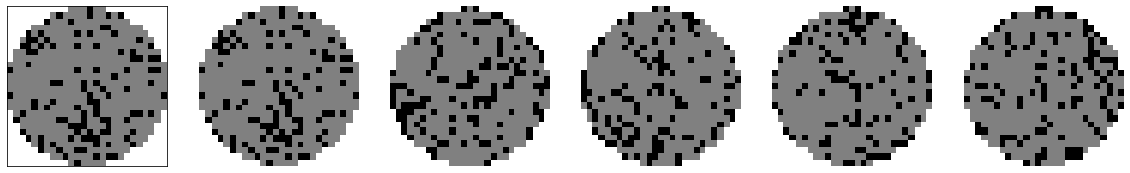

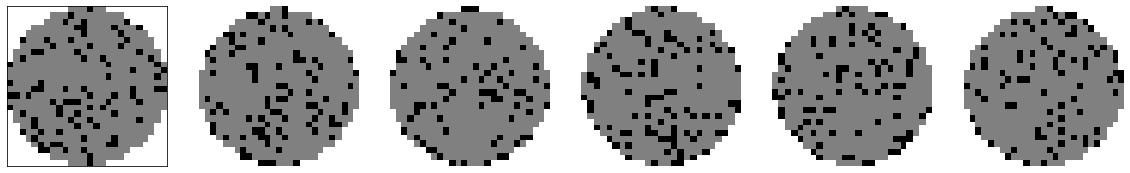

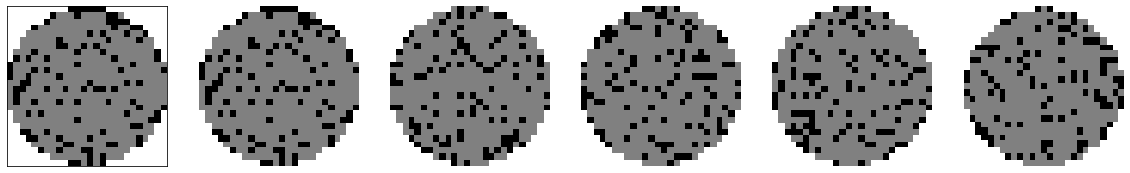

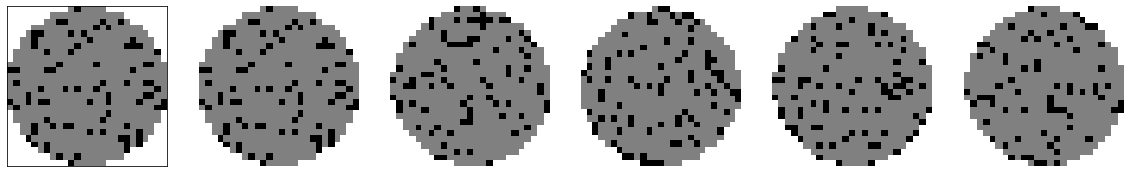

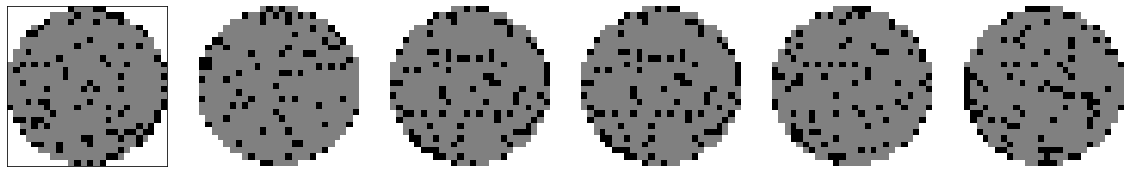

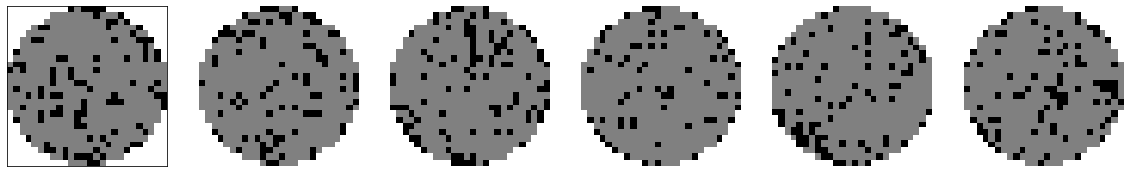

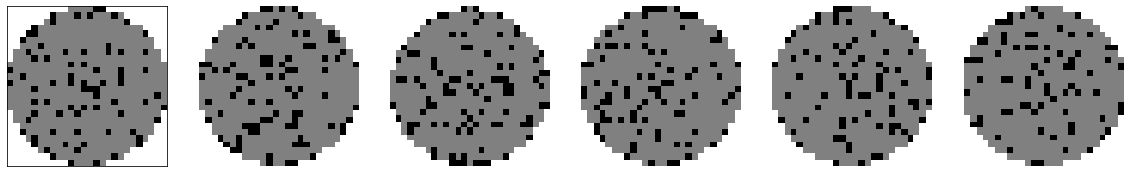

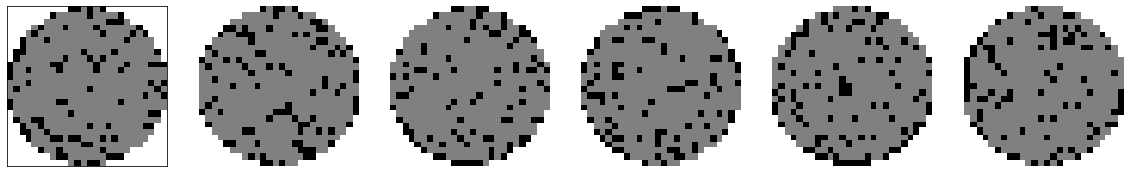

In [54]:
label_count = {l: 0 for l, _ in WM811K_LABELS.items()}

COUNT = 0
SIZE = (112, 112)
for i, (image_path, target) in enumerate(test_set.samples):
    
    label = target2label[target]
    if label != LABEL_OF_INTEREST:
        continue
    
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    
    # Query image (from test set)
    query_image = Image.open(image_path)
    axes[0].imshow(query_image.resize(SIZE, resample=Image.NEAREST), cmap=plt.cm.binary)
    axes[0].tick_params(axis='both', which='both', 
                        left=False, bottom=False, top=False, 
                        labelleft=False, labelbottom=False)
    #axes[0].set_title(f'Query ({i:,}, Label: {label})')
    
    # Nearest neighbor images (k=5)
    for ax, n_ind in zip(axes[1:], neigh_ind[i]):
        image_path, target = train_set.samples[n_ind]
        ax.imshow(Image.open(image_path).resize(SIZE, resample=Image.NEAREST), cmap=plt.cm.binary)
        #ax.set_title(f'{n_ind:,}, Label: {target2label[target]}')
        ax.axis('off')
        
    if COUNT > MAX_COUNT:
        break
    
    COUNT += 1

# Visualization

In [ ]:
%%time

# T-SNE
tsne = TSNE(n_components=2, perplexity=50, verbose=1)
Z_tsne = pd.DataFrame(tsne.fit_transform(test_embeddings))
Z_tsne.columns = ['D1', 'D2']
Z_tsne['label'] = [target2label[t] for t in test_targets]

In [ ]:
fig = px.scatter(Z_tsne, x='D1', y='D2', color='label')
fig.show()

In [ ]:
%%time

# Multidimensional Scaling (MDS)
mds = MDS(n_components=2, metric=True, dissimilarity='euclidean', n_jobs=8)
Z = pd.DataFrame(mds.fit_transform(test_embeddings))
Z.columns = ['D1', 'D2']

In [ ]:
from datasets.wafer import WM811K_LABELS

In [ ]:
Z.shape

In [ ]:
pca = PCA(n_components=3)
Z = pd.DataFrame(pca.fit_transform(test_embeddings))
Z.columns = [f"PC{i+1}" for i in range(pca.n_components_)]

In [ ]:
Z['targets'] = test_targets

In [ ]:
scatter_kwargs = dict(x='PC1', y='PC2', z='PC3', color='targets')
fig = px.scatter_3d(Z, **scatter_kwargs)
fig.show()

In [ ]:
def plot_PCA(X: np.ndarray, targets: np.ndarray, **kwargs):
    """Plot 2D scatter plot with PCA."""
    
    pca = PCA()
    Z = pca.fit_transform(X)
    
    fig, ax = plt.subplots(1, 1, figsize=kwargs.get('figsize', (10, 10)))
    ax.scatter(Z[:, 0], Z[:, 1], c=targets, alpha=0.25, cmap=kwargs.get('cmap', plt.cm.Set2))
    plt.show(fig)
    

In [ ]:
plot_PCA(test_embeddings, test_targets)

In [ ]:
list(range(1, 3))